# 200 - First percepton with pytorch

First perception on MNIST database.

**Note:** install [tqdm](https://pypi.python.org/pypi/tqdm) if not installed: ``!pip install tqdm``

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
print("torch", torch.__version__)
from torchvision import datasets, transforms
from tqdm import tqdm

torch 1.0.1


In [2]:
%matplotlib inline

In [3]:
BATCH_SIZE = 64
TEST_BATCH_SIZE = 64
DATA_DIR = 'data/'
USE_CUDA = True
N_EPOCHS = 100

In [4]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(DATA_DIR, train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(DATA_DIR, train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=TEST_BATCH_SIZE, shuffle=True)

100%|███████████████████████████████████████████████████████████████████▊| 9887744/9912422 [00:23<00:00, 886345.85it/s]

Extracting data/MNIST\raw\train-images-idx3-ubyte.gz



0it [00:00, ?it/s]
  0%|                                                                                        | 0/28881 [00:01<?, ?it/s]
32768it [00:01, 25286.13it/s]                                                                                          

Extracting data/MNIST\raw\train-labels-idx1-ubyte.gz



0it [00:00, ?it/s]
 93%|███████████████████████████████████████████████████████████████▏    | 1531904/1648877 [00:02<00:00, 939358.03it/s]
1654784it [00:02, 709177.59it/s]                                                                                       

Extracting data/MNIST\raw\t10k-images-idx3-ubyte.gz



0it [00:00, ?it/s]
  0%|                                                                                         | 0/4542 [00:00<?, ?it/s]
8192it [00:00, 46283.28it/s]                                                                                           

Extracting data/MNIST\raw\t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [5]:
data, target = next(i for i in train_loader)

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.tanh(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=-1)

In [7]:
model = Net()

if USE_CUDA: 
    try:
        model = model.cuda()
    except Exception as e:
        print(e)
        USE_CUDA = False
        N_EPOCHS = 5

Torch not compiled with CUDA enabled


In [8]:
optimizer = optim.Adam(model.parameters())

In [9]:
def train(epoch, verbose=True):
    model.train()
    losses = []
    loader = tqdm(train_loader, total=len(train_loader))
    for batch_idx, (data, target) in enumerate(loader):
        if USE_CUDA:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        losses.append(float(loss.data.item()))
        if verbose and batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return np.mean(losses)

In [10]:
def test(verbose=True):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if USE_CUDA: 
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.nll_loss(output, target, size_average=False).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(test_loader.dataset)
    if verbose:
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))
    return [float(test_loss), correct]

In [11]:
perfs = []
for epoch in range(1, N_EPOCHS + 1):
    t0 = time.time()
    train_loss = train(epoch, verbose=False)
    test_loss, correct = test(verbose=False)
    perfs.append([epoch, train_loss, test_loss, 
                  correct, len(test_loader.dataset), time.time() - t0])
    print("epoch {}: train loss {:.4f}, test loss {:.4f}, accuracy {}/{} in {:.2f}s".format(*perfs[-1]))


  0%|                                                                                          | 0/938 [00:00<?, ?it/s]c:\Python372_x64\lib\site-packages\torch\nn\functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

 50%|████████████████████████████████████████▎                                       | 472/938 [00:07<00:08, 57.37it/s]


 73%|██████████████████████████████████████████████████████████▍                     | 685/938 [00:11<00:04, 62.93it/s]
9920512it [00:40, 886345.85it/s]                                                                                       
100%|███████████████████████████████████████████████████████████████████████████████▊| 936/938 [00:15<00:00, 71.38it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:15<00:00, 61.66it/s]c:\Python372_x64\lib\site-packages\ipykernel_launcher.py:8: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  
c:\Python372_x64\lib\site-packages\torch\nn\_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


epoch 1: train loss 0.4818, test loss 0.2717, accuracy 9208/10000 in 17.19s



 54%|██████████████████████████████████████████▉                                     | 504/938 [00:07<00:06, 68.29it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:14<00:00, 66.56it/s]

epoch 2: train loss 0.3394, test loss 0.2178, accuracy 9363/10000 in 16.03s



 52%|█████████████████████████████████████████▋                                      | 489/938 [00:07<00:06, 68.33it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:14<00:00, 66.73it/s]

epoch 3: train loss 0.3116, test loss 0.2070, accuracy 9377/10000 in 15.83s



 55%|███████████████████████████████████████████▊                                    | 514/938 [00:07<00:06, 70.54it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:13<00:00, 69.28it/s]

epoch 4: train loss 0.3007, test loss 0.1923, accuracy 9431/10000 in 15.32s



 55%|███████████████████████████████████████████▉                                    | 515/938 [00:07<00:06, 66.05it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:13<00:00, 67.49it/s]

epoch 5: train loss 0.2860, test loss 0.1910, accuracy 9418/10000 in 15.69s


In [12]:
df_perfs = pd.DataFrame(perfs, columns=["epoch", "train_loss", "test_loss",
                                        "accuracy", "n_test", "time"])
df_perfs

,epoch,train_loss,test_loss,accuracy,n_test,time
0,1,0.481775,0.271653,9208,10000,17.192371
1,2,0.339388,0.217762,9363,10000,16.030911
2,3,0.311572,0.207010,9377,10000,15.826030
3,4,0.300691,0.192308,9431,10000,15.321946
4,5,0.285966,0.191044,9418,10000,15.687925


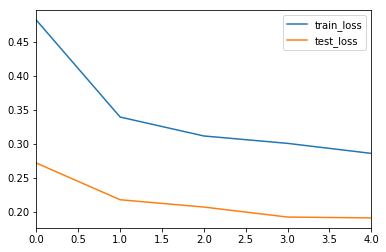

In [13]:
df_perfs[["train_loss", "test_loss"]].plot();

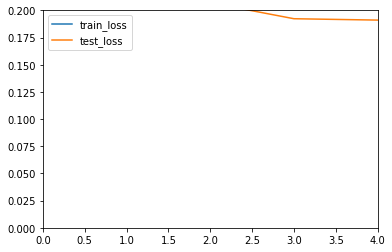

In [14]:
df_perfs[["train_loss", "test_loss"]].plot(ylim=(0, 0.2));